# Oxford Battery Dataset Preprocessing
This notebook loads and preprocesses the Oxford Battery Dataset (CSV format), normalizes capacity, computes RUL, and visualizes degradation curves.

In [42]:
# --- 1. Setup ---
import os
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import trapezoid as trapz

sns.set(style="whitegrid")
print("Libraries loaded successfully.")

Libraries loaded successfully.


In [43]:
# --- 3. Load and Extract Data from .mat File ---
file_path = '../data/raw/Oxford/Oxford_Battery_Degradation_Dataset_1.mat'  # Update path
data = sio.loadmat(file_path)
print(data.keys())  # Inspect top-level keys

all_cycles = []
cell_keys = [key for key in data.keys() if key.startswith('Cell')]

global_cycle_idx = 0  # Unique cycle index across all cells and subfields

for cell_key in cell_keys:
    cell_data = data[cell_key][0, 0]  # Access the struct for the cell
    print(f"Fields in {cell_key}: {cell_data.dtype.names}")  # Debug field names
    
    # Iterate over all cycle fields (e.g., 'cyc0000', 'cyc0100', etc.)
    for cycle_field in cell_data.dtype.names:
        cycle_struct = cell_data[cycle_field][0, 0]  # Access the struct
        print(f"Processing {cell_key} - {cycle_field}, fields: {cycle_struct.dtype.names}")
        
        # Process each subfield as a potential cycle
        for subfield in cycle_struct.dtype.names:
            if subfield.startswith('C1'):  # 1C cycles
                cycle = cycle_struct[subfield][0, 0]
                cycle_type = 'discharge' if subfield.endswith('dc') else 'charge'
                total_time = 3600  # 1C duration (s)
            elif subfield.startswith('OCV'):  # OCV cycles
                cycle = cycle_struct[subfield][0, 0]
                cycle_type = 'discharge' if subfield.endswith('dc') else 'charge'
                total_time = 64800  # C/18 duration (s)
            else:
                continue  # Skip invalid subfields
            
            # Debug the cycle struct contents
            print(f"  Subfield {subfield}, cycle fields: {cycle.dtype.names}")
            
            # Extract data with Oxford-specific field names
            time = cycle['t'].flatten() if 't' in cycle.dtype.names and cycle['t'].size > 0 else np.array([])
            if len(time) > 0:
                time = time - time[0]  # Normalize to start at 0
            voltage = cycle['v'].flatten() if 'v' in cycle.dtype.names and cycle['v'].size > 0 else np.array([])
            charge = cycle['q'].flatten() if 'q' in cycle.dtype.names and cycle['q'].size > 0 else np.array([])
            temperature = cycle['T'].flatten() if 'T' in cycle.dtype.names and cycle['T'].size > 0 else np.array([])
            
            # Compute capacity from the last charge value (mAh to Ah)
            if len(charge) > 0 and cycle_type == 'discharge' and charge.size > 0:
                capacity = abs(charge[-1]) / 1000  # Convert mAh to Ah
                # Sanity check for OCVdc expected capacity (~569 mAh, allow up to ~740 mAh)
                if subfield == 'OCVdc' and abs(charge[-1]) > 750:
                    print(f"Warning: OCVdc capacity {abs(charge[-1])} mAh exceeds expected ~740 mAh")
                    capacity = np.nan  # Flag anomaly
            else:
                capacity = np.nan
            
            mean_voltage = np.mean(voltage) if len(voltage) > 0 else np.nan
            mean_temperature = np.mean(temperature) if len(temperature) > 0 else np.nan
            
            # Compute current as average current over the cycle
            current = np.nan
            if capacity is not np.nan and total_time > 0:
                current = -capacity / (total_time / 3600) if cycle_type == 'discharge' else capacity / (total_time / 3600)
            
            # Debug time and charge arrays
            print(f"    Time array shape: {time.shape if len(time) > 0 else 'empty'}, values: {time[:5]}... (length: {len(time)}, range: {np.ptp(time) if len(time) > 0 else 0})")
            print(f"    Charge array shape: {charge.shape if len(charge) > 0 else 'empty'}, values: {charge[:5]}... (length: {len(charge)}, last: {charge[-1] if len(charge) > 0 else None})")
            
            global_cycle_idx += 1  # Increment for each subfield
            all_cycles.append({
                'Battery_ID': cell_key,
                'Cycle_Index': global_cycle_idx,
                'Capacity_Ah': capacity,
                'Voltage_V': mean_voltage,
                'Current_A': current,
                'Temperature_C': mean_temperature,
                'Time_s': total_time,
                'Cycle_Type': cycle_type
            })

df_oxford = pd.DataFrame(all_cycles)
print("\nData loaded from Oxford Battery Degradation Dataset 1 into DataFrame.")
print(f"Total cycles loaded: {len(df_oxford)}")
print(f"Discharge cycles: {len(df_oxford[df_oxford['Cycle_Type'] == 'discharge'])}")
print(df_oxford.head())

dict_keys(['__header__', '__version__', '__globals__', 'Cell1', 'Cell2', 'Cell3', 'Cell4', 'Cell5', 'Cell6', 'Cell7', 'Cell8'])
Fields in Cell1: ('cyc0000', 'cyc0100', 'cyc0200', 'cyc0300', 'cyc0400', 'cyc0500', 'cyc0600', 'cyc0700', 'cyc0800', 'cyc0900', 'cyc1000', 'cyc1100', 'cyc1200', 'cyc1300', 'cyc1400', 'cyc1600', 'cyc1800', 'cyc1900', 'cyc2000', 'cyc2100', 'cyc2200', 'cyc2300', 'cyc2400', 'cyc2500', 'cyc2600', 'cyc2700', 'cyc2800', 'cyc2900', 'cyc3000', 'cyc3100', 'cyc3200', 'cyc3300', 'cyc3500', 'cyc3600', 'cyc3700', 'cyc3800', 'cyc3900', 'cyc4000', 'cyc4100', 'cyc4200', 'cyc4300', 'cyc4400', 'cyc4500', 'cyc4600', 'cyc4800', 'cyc5000', 'cyc5100', 'cyc5200', 'cyc5300', 'cyc5400', 'cyc5500', 'cyc5600', 'cyc5700', 'cyc5800', 'cyc5900', 'cyc6000', 'cyc6100', 'cyc6200', 'cyc6300', 'cyc6400', 'cyc6500', 'cyc6600', 'cyc6700', 'cyc6800', 'cyc6900', 'cyc7000', 'cyc7100', 'cyc7200', 'cyc7300', 'cyc7400', 'cyc7500', 'cyc7600', 'cyc7700', 'cyc7800', 'cyc7900', 'cyc8000', 'cyc8100', 'cyc820

In [44]:
print("\nBasic Statistics:")
print(df_oxford.describe())

print("\nUnique battery IDs:")
print(df_oxford['Battery_ID'].unique())


Basic Statistics:
       Cycle_Index  Capacity_Ah    Voltage_V    Current_A  Temperature_C  \
count    2076.0000  1038.000000  2076.000000  1038.000000    2076.000000   
mean     1038.5000     0.640648     3.795987    -0.336504      40.234872   
std       599.4339     0.048259     0.040170     0.302893       2.501857   
min         1.0000     0.456129     3.664735    -0.739111       0.520210   
25%       519.7500     0.600885     3.752152    -0.633250      40.103364   
50%      1038.5000     0.636540     3.796395    -0.248615      40.405927   
75%      1557.2500     0.679996     3.826504    -0.035532      40.831437   
max      2076.0000     0.739820     3.876258    -0.028498      41.811586   

             Time_s  
count   2076.000000  
mean   34200.000000  
std    30607.372606  
min     3600.000000  
25%     3600.000000  
50%    34200.000000  
75%    64800.000000  
max    64800.000000  

Unique battery IDs:
['Cell1' 'Cell2' 'Cell3' 'Cell4' 'Cell5' 'Cell6' 'Cell7' 'Cell8']


In [45]:
# Impute low temperature values
low_temp_mask = df_oxford['Temperature_C'] < 20
if low_temp_mask.any():
    print(f"Warning: {low_temp_mask.sum()} rows with Temperature_C < 20 detected. Imputing with mean: {df_oxford['Temperature_C'].mean():.6f}°C")
    df_oxford.loc[low_temp_mask, 'Temperature_C'] = df_oxford['Temperature_C'].mean()

# --- 4. Normalize Capacity ---
# Compute initial capacity per battery
initial_capacities = df_oxford[df_oxford['Cycle_Type'] == 'discharge'].groupby('Battery_ID')['Capacity_Ah'].max()
# Merge initial capacities into the DataFrame
df_oxford = df_oxford.merge(initial_capacities.rename('initial_capacity'), on='Battery_ID', how='left')
# Normalize capacity only for discharge cycles
df_oxford['norm_capacity'] = np.where(
    df_oxford['Cycle_Type'] == 'discharge',
    df_oxford['Capacity_Ah'] / df_oxford['initial_capacity'],
    np.nan
)

In [46]:
# --- 5. Compute RUL ---
failure_threshold = 0.8  # 80% of initial capacity

def compute_rul(group):
    failed_cycle = group[group['norm_capacity'] <= failure_threshold]['Cycle_Index'].min()
    if pd.isna(failed_cycle):  # if never failed
        failed_cycle = group['Cycle_Index'].max()
    group['RUL'] = failed_cycle - group['Cycle_Index']
    return group

# Ensure Battery_ID is a column, not an index
df_oxford = df_oxford.reset_index(drop=True)
df_oxford = df_oxford.groupby('Battery_ID', group_keys=False).apply(compute_rul)
print("RUL computed.")

# Display results
print("\nBasic Statistics:")
print(df_oxford.describe())

print("\nUnique battery IDs:")
print(df_oxford['Battery_ID'].unique())

print("\nFirst few rows with RUL:")
print(df_oxford.head())

RUL computed.

Basic Statistics:
       Cycle_Index  Capacity_Ah    Voltage_V    Current_A  Temperature_C  \
count    2076.0000  1038.000000  2076.000000  1038.000000    2076.000000   
mean     1038.5000     0.640648     3.795987    -0.336504      40.311393   
std       599.4339     0.048259     0.040170     0.302893       1.792478   
min         1.0000     0.456129     3.664735    -0.739111      23.230379   
25%       519.7500     0.600885     3.752152    -0.633250      40.105120   
50%      1038.5000     0.636540     3.796395    -0.248615      40.405927   
75%      1557.2500     0.679996     3.826504    -0.035532      40.831437   
max      2076.0000     0.739820     3.876258    -0.028498      41.811586   

             Time_s  initial_capacity  norm_capacity          RUL  
count   2076.000000       2076.000000    1038.000000  2076.000000  
mean   34200.000000          0.733940       0.872916    80.794798  
std    30607.372606          0.003700       0.065944    86.362538  
min     36

C:\Users\mufas\AppData\Local\Temp\ipykernel_25644\1533962843.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_oxford = df_oxford.groupby('Battery_ID', group_keys=False).apply(compute_rul)


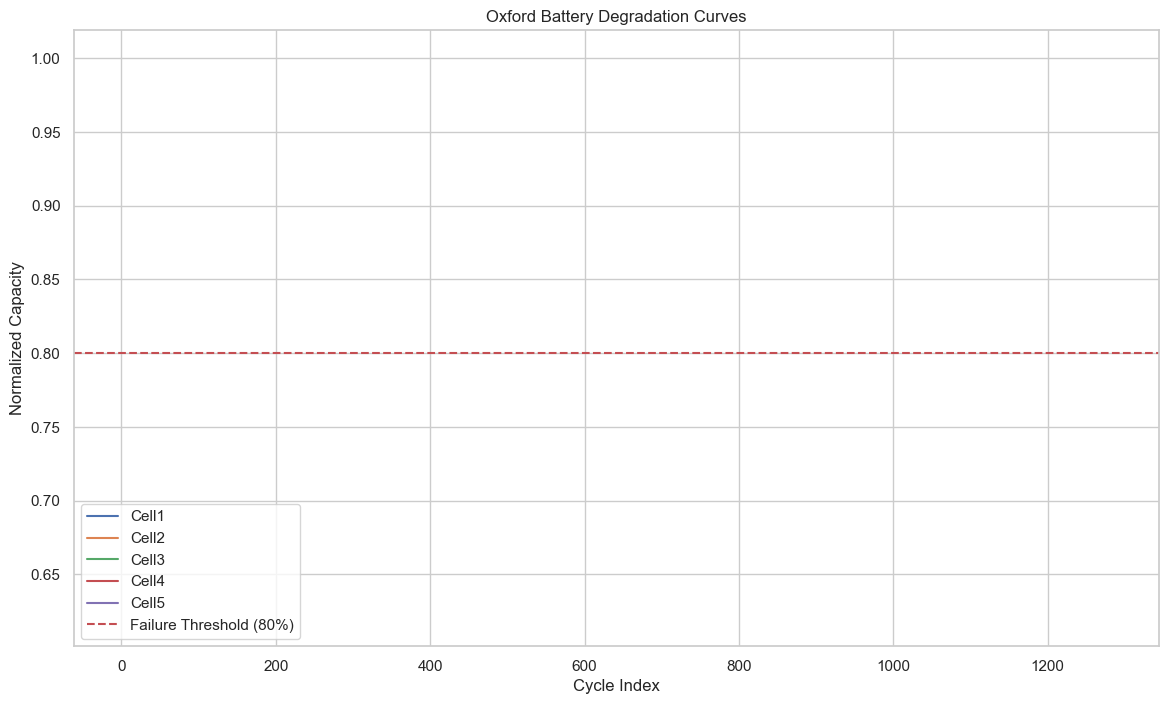

In [47]:
# --- 6. Visualize Degradation Curves ---
plt.figure(figsize=(14, 8))
batteries_to_plot = df_oxford['Battery_ID'].unique()[:5]  # plot first 5 batteries

for bat_id in batteries_to_plot:
    subset = df_oxford[df_oxford['Battery_ID'] == bat_id]
    plt.plot(subset['Cycle_Index'], subset['norm_capacity'], label=bat_id)

plt.axhline(y=0.8, color='r', linestyle='--', label='Failure Threshold (80%)')
plt.xlabel('Cycle Index')
plt.ylabel('Normalized Capacity')
plt.title('Oxford Battery Degradation Curves')
plt.legend()
plt.grid(True)
plt.show()

In [48]:
# --- 7. Save Processed Data ---
output_path = 'data/processed/oxford_battery_degradation.csv'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df_oxford.to_csv(output_path, index=False)
print(f"Processed data saved to {output_path}")

Processed data saved to data/processed/oxford_battery_degradation.csv
